In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import datetime
warnings.simplefilter("ignore")

hive_number = 260
#filename = 'C:/Users/mhoss/Downloads/lm_optimization/C_'+str(hive_number)+'-no_hiccups.csv'
#filename = 'C:/Bee Temp Data/EBV_sig_seg - Copy of 281.csv'
filename = 'C:/Bee Temp Data/EBV_sig_seg - 260.csv'
hive_no = hive_number

data = pd.read_csv(filename)
#data = data[['Date','Time','DateTime','Temp_Box','Temp_Easy_281','Temp_281']][25*24:42*24]
data = data[['Date','Time','DateTime','Temp_Box','Temp_Easy_260','Temp_260']]
data = data.reset_index()
data.tail()

,index,Date,Time,DateTime,Temp_Box,Temp_Easy_260,Temp_260
1339,1339,2021-09-27,19:00:00,27/09/21 19:00,17.333333,28.833333,32.000000
1340,1340,2021-09-27,20:00:00,27/09/21 20:00,16.500000,27.916667,31.333333
1341,1341,2021-09-27,21:00:00,27/09/21 21:00,16.000000,27.333333,31.000000
1342,1342,2021-09-27,22:00:00,27/09/21 22:00,16.500000,26.500000,31.000000
1343,1343,2021-09-27,23:00:00,27/09/21 23:00,16.833333,26.583333,31.000000


In [2]:
import datetime
from datetime import timedelta
import warnings
warnings.simplefilter("ignore")
for i in range(len(data)):
    current_date = (datetime.datetime.strptime(str(data['Date'].values[i]), "%Y-%m-%d")).date()
    current_time = datetime.datetime.strptime(str(data['Time'].values[i]), "%H:%M:%S").time()
    current_datetime = datetime.datetime.combine(current_date,current_time)
    data['DateTime'][i] = datetime.datetime.strptime(str(current_datetime), "%Y-%m-%d %H:%M:%S").strftime('%m-%d-%Y %H:%M:%S')
    data['Time'][i] = datetime.datetime.strptime(str(current_datetime), "%Y-%m-%d %H:%M:%S").time().strftime('%H:%M:%S')
print(data.head())

   index        Date      Time             DateTime   Temp_Box  Temp_Easy_260  \
0      0  2021-08-03  00:00:00  08-03-2021 00:00:00  19.833333      29.666667   
1      1  2021-08-03  01:00:00  08-03-2021 01:00:00  19.000000      29.333333   
2      2  2021-08-03  02:00:00  08-03-2021 02:00:00  18.500000      28.916667   
3      3  2021-08-03  03:00:00  08-03-2021 03:00:00  18.000000      28.250000   
4      4  2021-08-03  04:00:00  08-03-2021 04:00:00  17.333333      28.166667   

   Temp_260  
0      35.0  
1      35.0  
2      35.0  
3      35.0  
4      35.0  


In [3]:
from lmfit import minimize, Parameters, Parameter, report_fit
import scipy.integrate as scint
import numpy as np
import math
import warnings
import time
import scipy.stats as st
import pandas as pd
import sys
import scipy.optimize as op
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from scipy.stats import bootstrap

def bee_eq(y, t, w1,w2, alpha, external_temperature, peri_, treatment,h):
    hive_temperature = y
    if treatment == 0:
        dydt = -h*w1*w2*(1-np.exp(-hive_temperature)) / (w2+w1*np.exp(-hive_temperature)) + 2*(-hive_temperature + external_temperature)
    else:
        dydt = -h*w1*w2*(1-np.exp(-hive_temperature)) / (w2+w1*np.exp(-hive_temperature)) + 2*(-hive_temperature) + peri_ + external_temperature
    return dydt

def run_bee_eq(t, a, w1, w2, alpha, ext_temp, peri_, treatment,h):
    sol = scint.odeint(bee_eq, a, t, args=(w1,w2, alpha, ext_temp, peri_, treatment,h), col_deriv = True, rtol = 10e-3, atol = 10e-3) #w' and 'amplitude_temp_ext'
    theta_t = sol[-1,:]
    return theta_t    

def residual(ps, ts, data_ext, data_temp, data_peri, l):
    model = []
    k = 0
    alpha = 1
    w1 = 80
    w2 = 221
    h_ = [1]
    return_value = []
    
    for n in range(int(len(data_ext)/24)):
        h = ps['h_'+str(k)].value
        theta_ideal = ps['theta_'+str(k)].value
        try:
            treatment = n['Treatment'].values[0]
        except:
            treatment = 0
        
        ext_temp_ = data_ext[n*24:(n+1)*24] - theta_ideal
        try:
            peri_ = data_peri[n*24:(n+1)*24] - theta_ideal 
        except:
            peri_ = ext_temp_
        truth_ = data_temp[n*24:(n+1)*24] - theta_ideal 
        t_max = len(ext_temp_)-1
        t = np.linspace(0,t_max, num = t_max+1)
        a = [1]*len(ext_temp_)
        fitted = run_bee_eq(t, a, w1, w2, alpha, ext_temp_, peri_, treatment, h) 
        model = np.concatenate((model, fitted + theta_ideal))
        
        try:
            h_.append(abs(h - ps['h_'+str(k-1)].value))
        except:
            h_.append(abs(h_[k] - h))
        k = k+1
    return_value = np.concatenate((return_value, (model - data_temp).ravel()))
    return_value = np.concatenate((return_value, l*np.array(h_[2:]).ravel()))
    return return_value

def residual_2(ps, ts, data_ext, data_temp, data_peri, l, h_min):
    model = []
    k = 0
    alpha = 1
    w1 = 80
    w2 = 221
    h_ = [h_min[-1]]
    return_value = []

    h = ps['h_'+str(k)].value
    theta_ideal = ps['theta_'+str(k)].value
    try:
        treatment = n['Treatment'].values[0]
    except:
        treatment = 0
        
    ext_temp_ = data_ext - theta_ideal
    try:
        peri_ = data_peri - theta_ideal 
    except:
        peri_ = ext_temp_
    truth_ = data_temp - theta_ideal 
    t_max = len(ext_temp_)-1
    t = np.linspace(0,t_max, num = t_max+1)
    a = [1]*len(ext_temp_)
    fitted = run_bee_eq(t, a, w1, w2, alpha, ext_temp_, peri_, treatment, h) 
    model = np.concatenate((model, fitted + theta_ideal))
        
    h_= np.concatenate((h_,[abs(h_[k] - h)]))
    return_value = np.concatenate((return_value, (model-data_temp).ravel()))
    return_value = np.concatenate((return_value, l*np.array(h_[1:]).ravel()))
    return return_value

0
1


KeyboardInterrupt: 

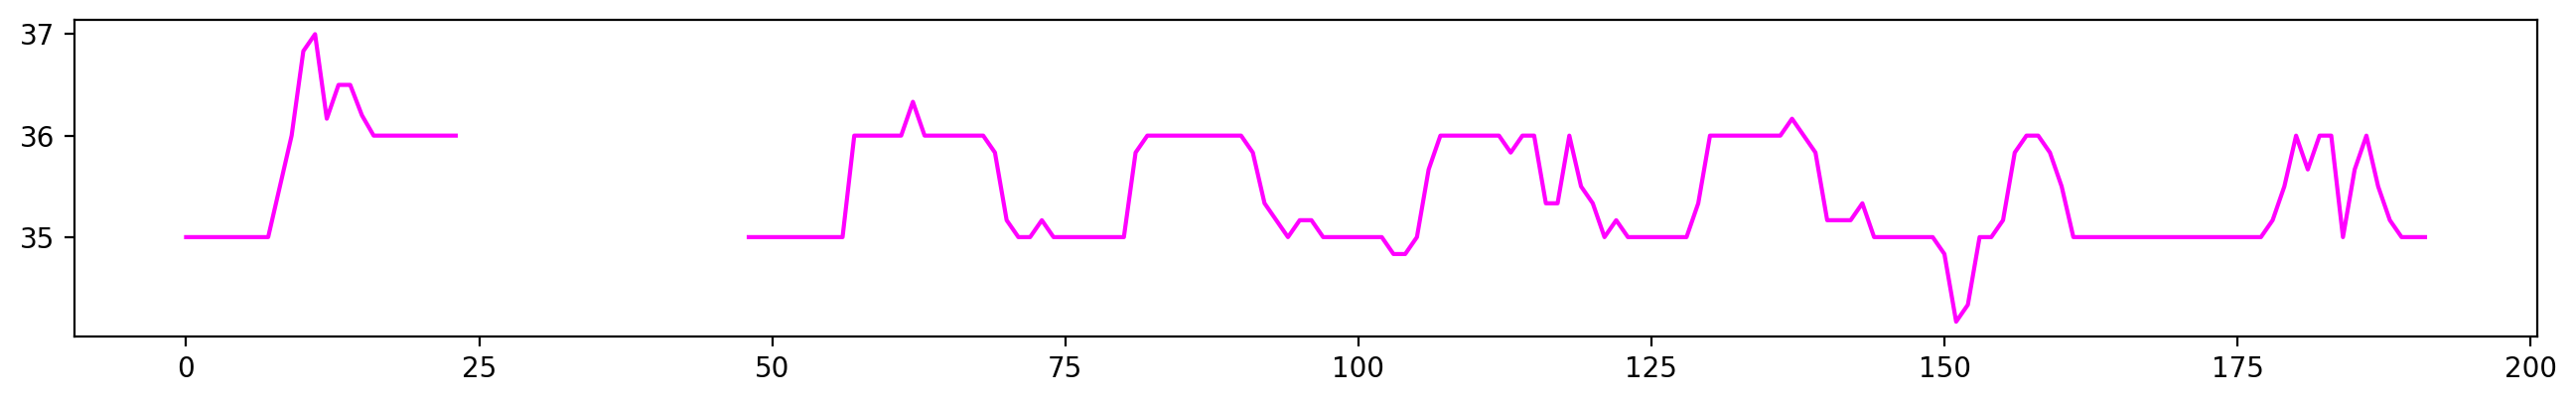

In [4]:
##input for forecasting -> done

import pandas as pd
hive_no = hive_number
h_max = 1
lambda_ = 96/h_max
data_forecasted = np.array([[],[],[],[],[],[],[],[],[],[],[]]).reshape(-1,11)
forecasted_all = []
data_low_std_all = []
data_high_std_all = []
w = 12
p = 3

count_orange = [0]*int(len(data)/24)
count_red = [0]*int(len(data)/24)

count_orange_silent = 0
count_red_silent = 0
count_red_cnt = -1
all_reds = [0]*int(len(data)/24)
start_orange = 0
end_orange = 0
start_red = 0
end_red = 0
plt.figure(figsize=(16, 12),dpi = 200)
xlabel = data['DateTime'].values
y = xlabel[range(0,len(xlabel),24)]
legend_properties = {'size': 12,'weight':'bold'}
ax1 = plt.subplot(511)
h_min_all = []
h_forecast = []
opening_dates = ['2021-08-17', '2021-08-18', '2021-09-01','2021-09-02', '2021-09-15', '2021-09-16']
for i in range(0,int(len(data)/24) - 7):
    print(i)
    if i == 0:
        continue
        
    d_input =  data[i*24:24*(i+7)]
    any_nan = True
    less_all = 0
    while any_nan:
        d_input = d_input[~pd.isnull(d_input['Temp_'+str(hive_no)].values) == True]
        if len(d_input) == 7*24:
            any_nan = False
        else:
            less_all = less_all + 7 - len(d_input)/24
            d_input =  data[(i-int(less_all))*24:24*(i+7)]
    if i == 1:
        ax1.plot(np.arange(len(data['Temp_'+str(hive_no)][0:(i+7)*24])), data['Temp_'+str(hive_no)][0:24*(i+7)].values, color = 'magenta', label = 'Input $\Theta(t)$')
        h_forecast = np.concatenate((h_forecast, [np.nan]*len(data['Temp_'+str(hive_no)][0:24*(i+7)])))
                
    d_input = d_input.reset_index(drop = True)
    data_temp = d_input['Temp_'+str(hive_no)][0:24*7]
    data_ext = d_input['Temp_Box'][0:24*7]
    try:
        data_peri = d_input['Temp_Easy_'+str(hive_no)][0:24*7]
    except:
        data_peri = data_ext

    l = lambda_
    if i == 1:
        params = Parameters()
        for j in range(7):
            params.add('h_'+str(j), value = np.random.ranf(), min = 0.1, max = h_max)
            params.add('theta_'+str(j), value = 35, min = 31, max = 38)

        t_max = len(data_ext)-1
        t = np.linspace(0,t_max, num = t_max+1)
        result = minimize(residual, params, args=(t,data_ext, data_temp, data_peri,l),method='least_squares',nan_policy='omit')
        sig_min = data_temp + result.residual[:len(data_temp)].reshape(data_temp.shape)
        h_min = []
        theta_ideal_min = []
        for m in range(7):
            h_min.append(result.params['h_'+str(m)].value)
        for m in range(7):
            theta_ideal_min.append(result.params['theta_'+str(m)].value)
        n = 0   
        for m in range(int(len(data['Temp_'+str(hive_no)][0:24*(i+7)])/24)):
            if str(data['Temp_'+str(hive_no)][m*24]) != 'nan':
                h_min_all = np.concatenate((h_min_all, [result.params['h_'+str(n)].value]*24))
                n = n+1
            else:
                h_min_all = np.concatenate((h_min_all, [np.nan]*24))
        
        ax2 = plt.subplot(512)
        ax2.plot(np.arange(len(h_min_all)), h_min_all, color = 'magenta', label = 'Input $h$', linewidth = 2)
        h_min_all = [np.nan]*len(data['Temp_'+str(hive_no)][0:24*(i+7)])
    
    else:
        sig_min = sig_min[-7*24:]
        
    h = h_min[-1]
    h_forecast = np.concatenate((h_forecast, [h_min[-1]]*24))
    
    theta_ideal = theta_ideal_min[-1]
    t = np.linspace(0,23, num = 24)
    a = [1]*len(t)
    w1 = 80
    w2 = 221
    alpha = 1

    d_forecast = data[(i+7)*24:(i+8)*24]
    ext_temp_ = d_forecast['Temp_Box'] - theta_ideal 
    hive_temp_ = d_forecast['Temp_'+str(hive_no)]
    try:
        peri_ = d_forecast['Temp_Easy_'+str(hive_no)] - theta_ideal 
    except:
        peri_ = ext_temp_
    try:
        treatment = d_forecast['Treatment'].values[0]
    except:
        treatment = 0
        
    if sum(pd.isnull(d_forecast['Temp_'+str(hive_no)].values)) == 24:
        h_min_all = np.concatenate((h_min_all, [np.nan]*24))
        x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+8)*24])-1, num = 24)
        ax1.plot(x, hive_temp_.values)
        
        if count_red[i+6]>=2:
            count_red[i+7] = count_red[i+6]+1
            count_red_cnt = 1
            all_reds[i+7] = 1
        
        
        #if count_red[i+6] >= 2:
        #    end_red = (i+8)*24-1
        #    x = np.linspace(len(data[0:start_red]), len(data[0:end_red]), num = end_red-start_red+1)
        #    ax1.fill_between(x, 25,40, color = 'r', alpha = 0.4)
        #    ax1.axvline(x = end_red, color='r', linewidth = 2)
        #    ax2.fill_between(x, 0,1, color = 'r', alpha = 0.4)
        #    ax2.axvline(x = end_red, color='r', linewidth = 2)
        #    start_red_silent = (i+8)*24
        #    count_red_silent = 1
        #    count_red_cnt = 0
            
        if count_red_silent >=1 and count_red_silent <= 4:
            count_red_silent = count_red_silent + 1
            
            if count_red_silent == 4:
                end_red_silent = (i+8)*24-1
                x = np.linspace(len(data[0:start_red_silent]), len(data[0:end_red_silent]), num = end_red_silent-start_red_silent+1)
                ax1.fill_between(x, 25,40, color = 'grey', alpha = 0.2)
                ax2.fill_between(x, 0,1, color = 'grey', alpha = 0.2)
                
        if count_orange[i+6] >= 2:
            end_orange = (i+7)*24-1
            print('end_orange', data['DateTime'].values[end_orange])
            x = np.linspace(len(data[0:start_orange]), len(data[0:end_orange]), num = end_orange-start_orange+1)
            ax1.fill_between(x, 25,40, color = 'orange', alpha = 0.3)
            ax1.axvline(x = end_orange, color='orange', linewidth = 2)
            ax2.fill_between(x, 0,1, color = 'orange', alpha = 0.3)
            ax2.axvline(x = end_orange, color='orange', linewidth = 2)
            start_orange_silent = (i+7)*24
            count_orange_silent = 1
            
        elif count_orange_silent >=1 and count_orange_silent <=3:
            count_orange_silent = count_orange_silent + 1
            
            if count_orange_silent == 3:
                end_orange_silent = (i+8)*24-1
                x = np.linspace(len(data[0:start_orange_silent]), len(data[0:end_orange_silent]), num = end_orange_silent-start_orange_silent+1)
                ax1.fill_between(x, 25,40, color = 'grey', alpha = 0.2)
                ax2.fill_between(x, 0,1, color = 'grey', alpha = 0.2)
        continue
        print('bye')
        
    
    forecasted = run_bee_eq(t, a, w1, w2, alpha, ext_temp_, peri_, treatment, h) + theta_ideal
        
    error_left = abs(sig_min - data_temp)
    
    error_forecast = forecasted - hive_temp_.values
    
    data_low_std, data_high_std = [0]*len(forecasted), [0]*len(forecasted)

    for x in range(len(forecasted)):
        bootstrap_ci = bootstrap((error_left,), np.std, confidence_level=0.95, random_state=1, method='basic')
        data_low_std[x] = forecasted[x] - 2*bootstrap_ci.confidence_interval.low
        data_high_std[x] = forecasted[x] + 2*bootstrap_ci.confidence_interval.high
        
    forecasted_all = np.concatenate((forecasted_all, forecasted))
    data_low_std_all = np.concatenate((data_low_std_all, data_low_std))
    data_high_std_all = np.concatenate((data_low_std_all, data_high_std))
    

    if i == 1:
        x = np.linspace(len(data[0:(i+7)*24])-1, len(data[0:(i+8)*24])-1, num = len(forecasted)+1)
        ax1.plot(x, data['Temp_'+str(hive_no)][(i+7)*24-1:(i+8)*24].values,  color = 'blue', linewidth = 2, label = "One day ahead Actual $\Theta(t)$")
        x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+8)*24])-1, num = len(forecasted))
        ax1.plot(x, forecasted, color = 'g', linestyle = 'dashed', linewidth = 2, label = "One day ahead Forecasted $\hat{\Theta}(t)$")
    elif i > 1:
        x = np.linspace(len(data[0:(i+7)*24])-1, len(data[0:(i+8)*24])-1, num = len(forecasted)+1)
        ax1.plot(x, data['Temp_'+str(hive_no)][(i+7)*24-1:(i+8)*24].values,  color = 'blue', linewidth = 2)    
        ax1.plot(x, forecasted_all[len(forecasted_all)-25:], color = 'g', linestyle = 'dashed', linewidth = 2)
        
    
    if count_red_silent >= 1 and count_red_silent <= 4:
        count_red_silent = count_red_silent + 1
        count_orange_silent = -1
        
        if count_red_silent <= 4:
            x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+8)*24])-1, num = len(data_low_std))
            ax1.fill_between(x,data_low_std, data_high_std, color='b', alpha=.3)
        
        if count_red_silent == 4:
            end_red_silent = (i+8)*24-1
            x = np.linspace(len(data[0:start_red_silent]), len(data[0:end_red_silent]), num = end_red_silent-start_red_silent+1)
            ax1.fill_between(x, 25,40, color = 'grey', alpha = 0.2)
            ax2.fill_between(x, 0,1, color = 'grey', alpha = 0.2)
            
    elif count_red_silent == 5:
        count_orange_silent = 0
        count_red_silent = 0
            
    if count_orange_silent >= 1 and count_orange_silent <=3:
        count_orange_silent = count_orange_silent + 1
        if count_orange_silent <= 4:
            x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+8)*24])-1, num = len(data_low_std))
            ax1.fill_between(x,data_low_std, data_high_std, color='b', alpha=.3)
            
        if count_orange_silent == 3:
            end_orange_silent = (i+8)*24-1
            x = np.linspace(len(data[0:start_orange_silent]), len(data[0:end_orange_silent]), num = end_orange_silent-start_orange_silent+1)
            ax1.fill_between(x, 25,40, color = 'grey', alpha = 0.2)
            ax2.fill_between(x, 0,1, color = 'grey', alpha = 0.2)
            
    params_forecast = Parameters()
    params_forecast.add('h_0', value = np.random.ranf(), min = 0.1, max = h_max)
    params_forecast.add('theta_0', value = 35, min = 31, max = 38)
    t_max = len(ext_temp_)-1
    t = np.linspace(0,t_max, num = t_max+1)
    result = minimize(residual_2, params_forecast, args=(t,d_forecast['Temp_Box'], d_forecast['Temp_'+str(hive_no)], d_forecast['Temp_Easy_'+str(hive_no)],l, h_min),method='least_squares',nan_policy='omit')
    sig_min = np.concatenate((sig_min, d_forecast['Temp_'+str(hive_no)] + result.residual[:len(d_forecast['Temp_'+str(hive_no)])].reshape(d_forecast['Temp_'+str(hive_no)].shape)))
    h_min = np.concatenate((h_min, [result.params['h_0'].value]))
    h_min_all = np.concatenate((h_min_all, [result.params['h_0'].value]*24))
    theta_ideal_min = np.concatenate((theta_ideal_min, [result.params['theta_0'].value]))
    
    if d_forecast['Date'].values[0] in opening_dates:
        x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+8)*24])-1, num = len(data_low_std))
        #ax1.fill_between(x,data_low_std, data_high_std, color='b', alpha=.3)
        
        if count_orange[i+6] >=2:
            end_orange = (i+7)*24-1
            print('end_orange', data['DateTime'].values[end_orange])
            x = np.linspace(len(data[0:start_orange]), len(data[0:end_orange]), num = end_orange-start_orange+1)
            ax1.fill_between(x, 25,40, color = 'orange', alpha = 0.3)
            ax1.axvline(x = end_orange, color='orange', linewidth = 2)
            ax2.fill_between(x, 0,1, color = 'orange', alpha = 0.3)
            ax2.axvline(x = end_orange, color='orange', linewidth = 2)
            count_orange_silent = 1
            start_orange_silent = (i+7)*24
            
        if count_red[i+6]>=2:
            count_red[i+7] = count_red[i+6]+1
            count_red_cnt = 1
            all_reds[i+7] = 1
            
        #if count_red[i+6] >=2:
        #    end_red = (i+7)*24-1
        #    x = np.linspace(len(data[0:start_red]), len(data[0:end_red]), num = end_red-start_red+1)
        #    ax1.fill_between(x, 25,40, color = 'orange', alpha = 0.3)
        #    ax1.axvline(x = end_red, color='orange', linewidth = 2)
        #    ax2.fill_between(x, 0,1, color = 'orange', alpha = 0.3)
        #    ax2.axvline(x = end_red, color='orange', linewidth = 2)
        #    count_red_silent = 1
        #    start_red_silent = (i+7)*24
        continue
        
    if i > 1 and count_orange_silent == 0 and sum(pd.isnull(data['Temp_'+str(hive_no)].values[(i+6)*24:(i+7)*24])) != 24:
        for j in range(12,0,-1):
            data_actual = data['Temp_'+str(hive_no)].values[((i+7)*24-j):((i+7)*24-j+w)]
            data_forecast = forecasted_all[len(forecasted_all)-24-j: len(forecasted_all)-24-j+w]
            data_low_forecast_partial = data_low_std_all[len(data_low_std_all)-24-j: len(data_low_std_all)-24-j+w]
            data_high_forecast_partial = data_high_std_all[len(data_high_std_all)-24-j: len(data_high_std_all)-24-j+w]
            out_of_range = np.array(data_low_forecast_partial > data_actual) + np.array(data_high_forecast_partial < data_actual)
                        
            points = [0]*w
            
            for a in range(len(out_of_range)):
                if out_of_range[a] == True:
                    points[a] = 1
                    b = a+1
                    if b <= (w-1):
                        #print(b)
                        while b <= (w-1) and out_of_range[b] == True:
                            points[a] = points[a]+1
                            b = b+1  
            if np.sum(np.array(points) > np.array([w/p]*w)) < 1 and count_orange[i+6] >= 2:
                end_orange = (i+7)*24-j+w-1
                print('end_orange', data['DateTime'].values[end_orange])
                x = np.linspace(len(data[0:start_orange]), len(data[0:end_orange]), num = end_orange-start_orange+1)
                ax1.fill_between(x, 25,40, color = 'orange', alpha = 0.3)
                ax1.axvline(x = end_orange, color='orange', linewidth = 2)
                ax2.fill_between(x, 0,1, color = 'orange', alpha = 0.3)
                ax2.axvline(x = end_orange, color='orange', linewidth = 2)
                count_orange_silent = 1
                start_orange_silent = (i+7)*24-j+w-1
                if (-j+w) == 0:
                    x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+8)*24])-1, num = len(data_low_std))
                    ax1.fill_between(x,data_low_std, data_high_std, color='b', alpha=.3)
                else:
                    x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+7)*24-j+w-1])-1, num = len(data[0:(i+7)*24-j+w-1])-len(data[0:(i+7)*24]))
                    ax1.fill_between(x,data_low_std[0:(-j+w-1)], data_high_std[0:(-j+w-1)], color='orange', alpha=1)
                    
                    x = np.linspace(len(data[0:(i+7)*24-j+w]), len(data[0:(i+8)*24])-1, num = len(data[0:(i+8)*24])-len(data[0:(i+7)*24-j+w]))
                    ax1.fill_between(x,data_low_std[(-j+w):], data_high_std[(-j+w):], color='b', alpha=.3)
                break

        
    if count_orange_silent == 0 or count_orange_silent == 4:
        count_orange_silent = 0
        for j in range(13):
            data_actual = hive_temp_.values[j:j+w]
            data_forecast = forecasted[j:j+w]
            data_low_forecast_partial = data_low_std[j:j+w]
            data_high_forecast_partial = data_high_std[j:j+w]
            out_of_range = np.array(data_low_forecast_partial > data_actual) + np.array(data_high_forecast_partial < data_actual)
                        
            points = [0]*w
        
            for a in range(len(out_of_range)):
                if out_of_range[a] == True:
                    points[a] = 1
                    b = a+1
                    #print(a,b,out_of_range)
                    if b <= (w-1):
                        #print(b)
                        while b <= (w-1) and out_of_range[b] == True:
                            points[a] = points[a]+1
                            b = b+1                        
            if np.sum(np.array(points) > np.array([w/p]*w)) >= 1:
                if count_orange[i+6] == 1 and count_orange[i+7] == 0:
                    ax1.axvline(x = (i+7)*24+j+w, color='orange', linewidth = 2)
                    ax2.axvline(x = (i+7)*24+j+w, color='orange', linewidth = 2)
                    count_orange[i+7] = 2
                    start_orange = (i+7)*24+j+w
                    print('start_orange', data['DateTime'].values[start_orange])
                elif count_orange[i+6] >= 2 and count_orange[i+7] == 0:
                    count_orange[i+7] = count_orange[i+6]+1
                elif count_orange[i+7] == 0:
                    count_orange[i+7] = 1
                    
        if count_orange[i+7]>=2 and (i+8)*24 == len(data):
            print('hi')
            end_orange = (i+8)*24-1
            print('end_orange', data['DateTime'].values[end_orange])
            x = np.linspace(len(data[0:start_orange]), len(data[0:end_orange]), num = end_orange-start_orange+1)
            ax1.fill_between(x, 25,40, color = 'orange', alpha = 0.3)
            ax1.axvline(x = end_orange, color='orange', linewidth = 2)
            ax2.fill_between(x, 0,1, color = 'orange', alpha = 0.3)
            ax2.axvline(x = end_orange, color='orange', linewidth = 2)

    if round(h_min[-2] - h_min[-1],4) < 0:
        print('hi')
        if count_orange[i+7] == 1:
            count_orange[i+7] = 0
        if count_orange[i+7] >= 2:
            end_orange = (i+8)*24-1
            print('end_orange', data['DateTime'].values[end_orange])
            x = np.linspace(len(data[0:start_orange]), len(data[0:end_orange]), num = end_orange-start_orange+1)
            ax1.fill_between(x, 25,40, color = 'orange', alpha = 0.3)
            ax1.axvline(x = end_orange, color='orange', linewidth = 2)
            ax2.fill_between(x, 0,1, color = 'orange', alpha = 0.3)
            ax2.axvline(x = end_orange, color='orange', linewidth = 2)
            count_orange_silent = 1
            start_orange_silent = (i+8)*24
    
    if count_red_silent == 0 or count_red_silent == 5:
        count_red_silent = 0
        if round(h_min[-1],2) <= 0.15:
            if count_red[i+6] == 1 and count_red[i+7] == 0:
                ax1.axvline(x = (i+8)*24-1, color='red', linewidth = 2)
                #ax2.axvline(x = (i+8)*24-1, color='red', linewidth = 2)
                count_red[i+7] = 2
                all_reds[i+7] = 1
                start_red = (i+8)*24-1
                count_red_cnt = 1
                print('start_red', data['DateTime'].values[start_red])
                
                if count_orange[i+7]>=2:
                    end_orange = (i+8)*24-2
                    print('end_orange', data['DateTime'].values[end_orange])
                    x = np.linspace(len(data[0:start_orange]), len(data[0:end_orange]), num = end_orange-start_orange+1)
                    ax1.fill_between(x, 25,40, color = 'orange', alpha = 0.3)
                    ax1.axvline(x = end_orange, color='orange', linewidth = 2)
                    ax2.fill_between(x, 0,1, color = 'orange', alpha = 0.3)
                    ax2.axvline(x = end_orange, color='orange', linewidth = 2)
            
            elif count_red[i+6] >= 2 and count_red[i+7] == 0:
                count_red[i+7] = count_red[i+6]+1
                count_red_cnt = 1
                all_reds[i+7] = 1
                
            elif count_red[i+7] == 0:
                count_red[i+7] = 1
            
        elif round(h_min[-1],2) > 0.15 and count_red_cnt == 1:
            start_red_silent = (i+8)*24
            count_red_silent = 1
            count_red_cnt = 0
            end_red = (i+8)*24-1
            print('end_red', data['DateTime'].values[end_red])
            x = np.linspace(len(data[0:start_red]), len(data[0:end_red]), num = end_red-start_red+1)
            ax1.fill_between(x, 25,40, color = 'red', alpha = 0.3)
            ax2.fill_between(x, 0,1, color = 'red', alpha = 0.3)
        
        if all_reds[i+7] == 1:
            count_orange_silent = -1
        
        if i == int(len(data)/24)-7-1 and round(h_min[-1],2) <= 0.15:
            end_red = (i+8)*24
            print('end_red', data['DateTime'].values[end_red])
            x = np.linspace(len(data[0:start_red]), len(data[0:end_red]), num = end_red-start_red+1)
            ax1.fill_between(x, 25,40, color = 'red', alpha = 0.3)
            ax1.axvline(x = end_red, color='red', linewidth = 2)
            ax2.fill_between(x, 0,1, color = 'red', alpha = 0.3)
            ax2.axvline(x = end_red, color='red', linewidth = 2)

    x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+8)*24])-1, num = 24)
    if count_orange[i+7] >= 1:
        ax1.fill_between(x,data_low_std, data_high_std, color='orange', alpha=1)
    else:
        ax1.fill_between(x,data_low_std, data_high_std, color='b', alpha=.3) 

ax2.plot(np.arange(len(h_min_all)), h_min_all, color = 'b', linewidth = 2, label = 'One day ahead Actual $h$')   
ax2.plot(np.arange(len(h_forecast)), h_forecast, color = 'g', linestyle = 'dashed', linewidth = 2, label = 'One day ahead Forecasted $\hat{h}$')    


xlabel = data['DateTime'].values
y = xlabel[range(0,len(xlabel),24)]            
ax1.legend(loc='lower left', prop=legend_properties)
ax1.yaxis.set_tick_params(labelsize=12)
ax1.xaxis.set_tick_params(labelsize=10)
ax1.set_ylabel("Temperature ($^0C$)", fontsize=12, fontweight='bold')
ax1.set_ylim([25,40])    
ax1.set_xticks(range(0,len(data['Date'].values),24))
#ax1.set_xticklabels(y,rotation=90)
#ax1.set_xlim([25*24,42*24-1])
#ax1.set_ymargin(0.1)
ax1.set_xticklabels([])
ax2.legend(loc='upper left', prop=legend_properties)
ax2.set_ylim([0,1])
ax2.yaxis.set_tick_params(labelsize=12)
ax2.xaxis.set_tick_params(labelsize=10)
ax2.set_ylabel("Health Factor, $h$", fontsize=12, fontweight='bold')
ax2.set_xlabel("Date & Time", fontsize = 14, fontweight='bold')
ax2.set_xticks(range(0,len(data['DateTime'].values),24))
ax2.set_xticklabels(y,rotation=90)
#plt.legend(loc='lower left', prop=legend_properties)
plt.show()

2
3
4
5
6
7
8
9
hi


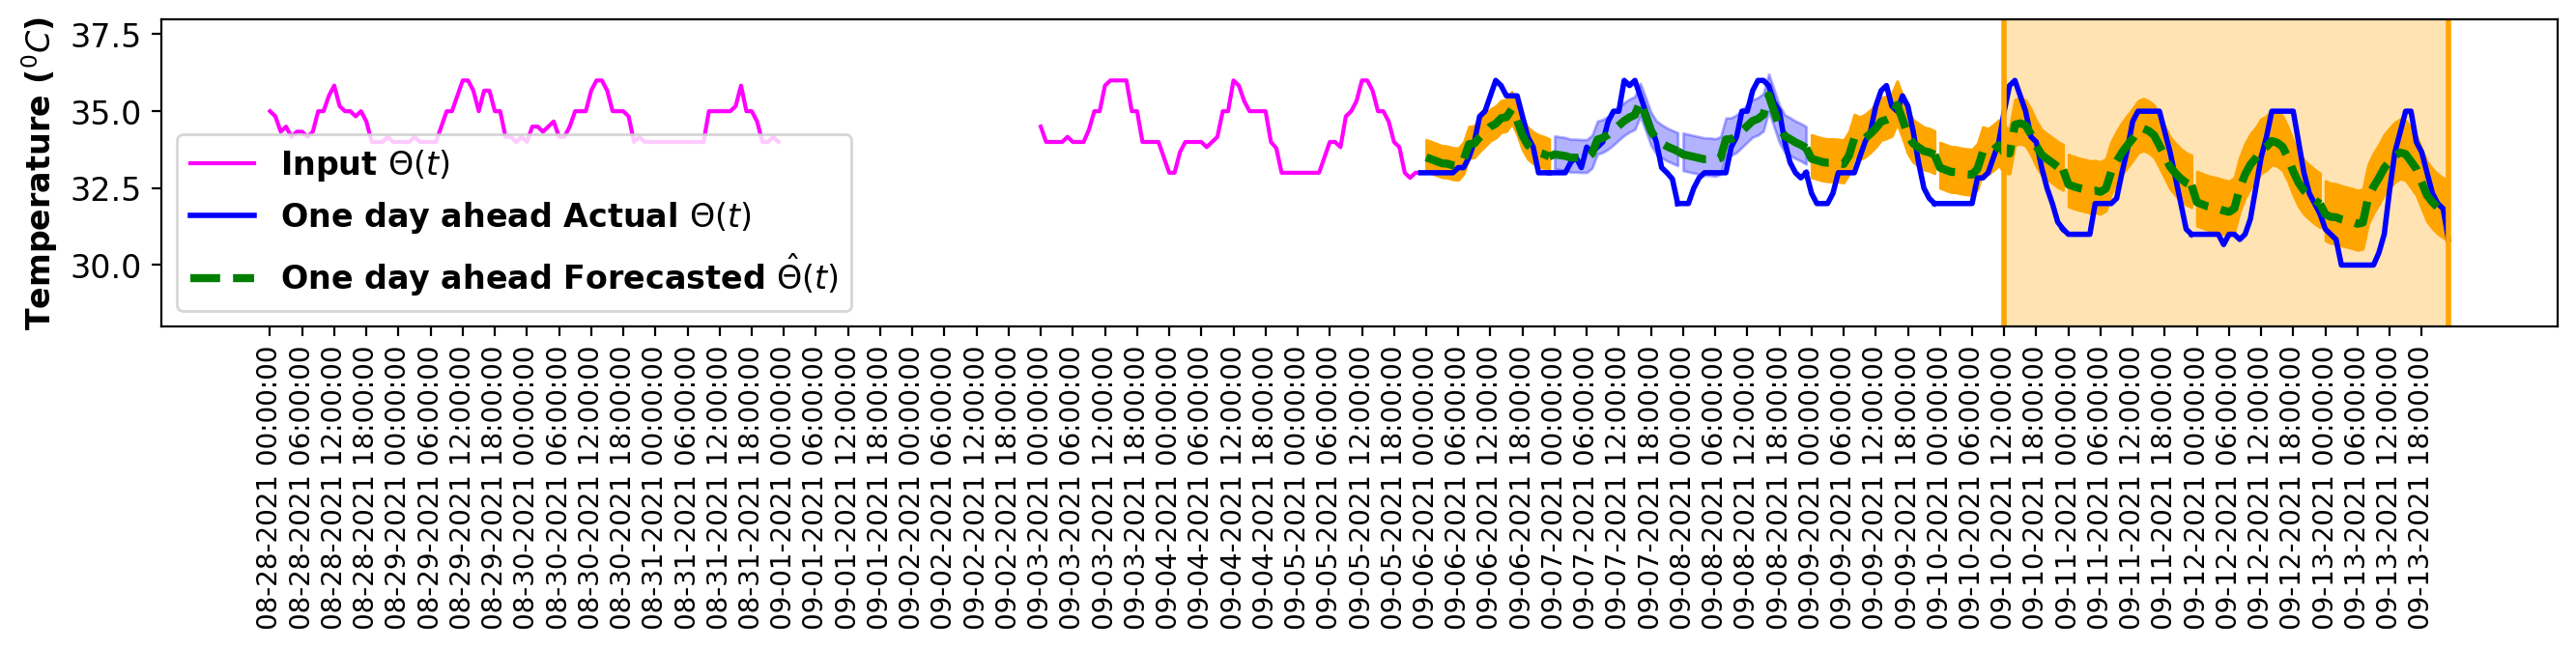

In [4]:
##input for forecasting -> done

import pandas as pd
hive_no = hive_number
h_max = 1
lambda_ = 96/h_max
data_forecasted = np.array([[],[],[],[],[],[],[],[],[],[],[]]).reshape(-1,11)
forecasted_all = []
data_low_std_all = []
data_high_std_all = []
w = 12
p = 3

count_orange = [0]*int(len(data)/24)
count_red = [0]*int(len(data)/24)

count_orange_silent = 0
count_red_silent = 0
count_red_cnt = -1
all_reds = [0]*int(len(data)/24)
start_orange = 0
end_orange = 0
start_red = 0
end_red = 0
plt.figure(figsize=(16, 12),dpi = 200)
xlabel = data['DateTime'].values
y = xlabel[range(0,len(xlabel),24)]
legend_properties = {'size': 12,'weight':'bold'}
ax1 = plt.subplot(511)
h_min_all = []
h_forecast = []
opening_dates = ['2021-08-17', '2021-08-18', '2021-09-01','2021-09-02', '2021-09-15', '2021-09-16']
for i in range(2,int(len(data)/24) - 7):
    print(i)
    if i == 0:
        continue
        
    d_input =  data[i*24:24*(i+7)]
    any_nan = True
    less_all = 0
    while any_nan:
        d_input = d_input[~pd.isnull(d_input['Temp_'+str(hive_no)].values) == True]
        if len(d_input) == 7*24:
            any_nan = False
        else:
            less_all = less_all + 7 - len(d_input)/24
            d_input =  data[(i-int(less_all))*24:24*(i+7)]
    if i == 2:
        ax1.plot(np.arange(len(data['Temp_'+str(hive_no)][0:(i+7)*24])), data['Temp_'+str(hive_no)][0:24*(i+7)].values, color = 'magenta', label = 'Input $\Theta(t)$')
        h_forecast = np.concatenate((h_forecast, [np.nan]*len(data['Temp_'+str(hive_no)][0:24*(i+7)])))
                
    d_input = d_input.reset_index(drop = True)
    data_temp = d_input['Temp_'+str(hive_no)][0:24*7]
    data_ext = d_input['Temp_Box'][0:24*7]
    try:
        data_peri = d_input['Temp_Easy_'+str(hive_no)][0:24*7]
    except:
        data_peri = data_ext

    l = lambda_
    if i == 2:
        params = Parameters()
        for j in range(7):
            params.add('h_'+str(j), value = np.random.ranf(), min = 0.1, max = h_max)
            params.add('theta_'+str(j), value = 35, min = 31, max = 38)

        t_max = len(data_ext)-1
        t = np.linspace(0,t_max, num = t_max+1)
        result = minimize(residual, params, args=(t,data_ext, data_temp, data_peri,l),method='least_squares',nan_policy='omit')
        sig_min = data_temp + result.residual[:len(data_temp)].reshape(data_temp.shape)
        h_min = []
        theta_ideal_min = []
        for m in range(7):
            h_min.append(result.params['h_'+str(m)].value)
        for m in range(7):
            theta_ideal_min.append(result.params['theta_'+str(m)].value)
        n = 0   
        for m in range(int(len(data['Temp_'+str(hive_no)][0:24*(i+7)])/24)):
            if str(data['Temp_'+str(hive_no)][m*24]) != 'nan':
                h_min_all = np.concatenate((h_min_all, [result.params['h_'+str(n)].value]*24))
                n = n+1
            else:
                h_min_all = np.concatenate((h_min_all, [np.nan]*24))
        
        #ax2 = plt.subplot(512)
        #ax2.plot(np.arange(len(h_min_all)), h_min_all, color = 'green', label = 'Input $h$', linewidth = 2)
        h_min_all = [np.nan]*len(data['Temp_'+str(hive_no)][0:24*(i+7)])
    
    else:
        sig_min = sig_min[-7*24:]
        
    h = h_min[-1]
    h_forecast = np.concatenate((h_forecast, [h_min[-1]]*24))
    
    theta_ideal = theta_ideal_min[-1]
    t = np.linspace(0,23, num = 24)
    a = [1]*len(t)
    w1 = 80
    w2 = 221
    alpha = 1

    d_forecast = data[(i+7)*24:(i+8)*24]
    ext_temp_ = d_forecast['Temp_Box'] - theta_ideal 
    hive_temp_ = d_forecast['Temp_'+str(hive_no)]
    try:
        peri_ = d_forecast['Temp_Easy_'+str(hive_no)] - theta_ideal 
    except:
        peri_ = ext_temp_
    try:
        treatment = d_forecast['Treatment'].values[0]
    except:
        treatment = 0
        
    if sum(pd.isnull(d_forecast['Temp_'+str(hive_no)].values)) == 24:
        h_min_all = np.concatenate((h_min_all, [np.nan]*24))
        x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+8)*24])-1, num = 24)
        ax1.plot(x, hive_temp_.values)
        
        if count_red[i+6]>=2:
            count_red[i+7] = count_red[i+6]+1
            count_red_cnt = 1
            all_reds[i+7] = 1
        
        
        #if count_red[i+6] >= 2:
        #    end_red = (i+8)*24-1
        #    x = np.linspace(len(data[0:start_red]), len(data[0:end_red]), num = end_red-start_red+1)
        #    ax1.fill_between(x, 25,40, color = 'r', alpha = 0.4)
        #    ax1.axvline(x = end_red, color='r', linewidth = 2)
        #    ax2.fill_between(x, 0,1, color = 'r', alpha = 0.4)
        #    ax2.axvline(x = end_red, color='r', linewidth = 2)
        #    start_red_silent = (i+8)*24
        #    count_red_silent = 1
        #    count_red_cnt = 0
            
        if count_red_silent >=1 and count_red_silent <= 4:
            count_red_silent = count_red_silent + 1
            
            if count_red_silent == 4:
                end_red_silent = (i+8)*24-1
                x = np.linspace(len(data[0:start_red_silent]), len(data[0:end_red_silent]), num = end_red_silent-start_red_silent+1)
                ax1.fill_between(x, 25,40, color = 'grey', alpha = 0.2)
                #ax2.fill_between(x, 0,1, color = 'grey', alpha = 0.2)
                
        if count_orange[i+6] >= 2:
            end_orange = (i+7)*24-1
            x = np.linspace(len(data[0:start_orange]), len(data[0:end_orange]), num = end_orange-start_orange+1)
            ax1.fill_between(x, 25,40, color = 'orange', alpha = 0.3)
            ax1.axvline(x = end_orange, color='orange', linewidth = 2)
            #ax2.fill_between(x, 0,1, color = 'orange', alpha = 0.3)
            #ax2.axvline(x = end_orange, color='orange', linewidth = 2)
            start_orange_silent = (i+7)*24
            count_orange_silent = 1
            
        elif count_orange_silent >=1 and count_orange_silent <=3:
            count_orange_silent = count_orange_silent + 1
            
            if count_orange_silent == 3:
                end_orange_silent = (i+8)*24-1
                x = np.linspace(len(data[0:start_orange_silent]), len(data[0:end_orange_silent]), num = end_orange_silent-start_orange_silent+1)
                ax1.fill_between(x, 25,40, color = 'grey', alpha = 0.2)
                #ax2.fill_between(x, 0,1, color = 'grey', alpha = 0.2)
        continue
        print('bye')
        
    
    forecasted = run_bee_eq(t, a, w1, w2, alpha, ext_temp_, peri_, treatment, h) + theta_ideal
        
    error_left = abs(sig_min - data_temp)
    
    error_forecast = forecasted - hive_temp_.values
    
    data_low_std, data_high_std = [0]*len(forecasted), [0]*len(forecasted)

    for x in range(len(forecasted)):
        bootstrap_ci = bootstrap((error_left,), np.std, confidence_level=0.95, random_state=1, method='basic')
        data_low_std[x] = forecasted[x] - 2*bootstrap_ci.confidence_interval.low
        data_high_std[x] = forecasted[x] + 2*bootstrap_ci.confidence_interval.high
        
    forecasted_all = np.concatenate((forecasted_all, forecasted))
    data_low_std_all = np.concatenate((data_low_std_all, data_low_std))
    data_high_std_all = np.concatenate((data_low_std_all, data_high_std))
    

    if i == 2:
        x = np.linspace(len(data[0:(i+7)*24])-1, len(data[0:(i+8)*24])-1, num = len(forecasted)+1)
        ax1.plot(x, data['Temp_'+str(hive_no)][(i+7)*24-1:(i+8)*24].values,  color = 'blue', linewidth = 2, label = "One day ahead Actual $\Theta(t)$")
        x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+8)*24])-1, num = len(forecasted))
        ax1.plot(x, forecasted, color = 'g', linestyle = 'dashed', linewidth = 3, label = "One day ahead Forecasted $\hat{\Theta}(t)$")
    elif i > 2:
        x = np.linspace(len(data[0:(i+7)*24])-1, len(data[0:(i+8)*24])-1, num = len(forecasted)+1)
        ax1.plot(x, data['Temp_'+str(hive_no)][(i+7)*24-1:(i+8)*24].values,  color = 'blue', linewidth = 2)    
        ax1.plot(x, forecasted_all[len(forecasted_all)-25:], color = 'g', linestyle = 'dashed', linewidth = 3)
        
    
    if count_red_silent >= 1 and count_red_silent <= 4:
        count_red_silent = count_red_silent + 1
        count_orange_silent = -1
        
        if count_red_silent <= 4:
            x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+8)*24])-1, num = len(data_low_std))
            ax1.fill_between(x,data_low_std, data_high_std, color='b', alpha=.3)
        
        if count_red_silent == 4:
            end_red_silent = (i+8)*24-1
            x = np.linspace(len(data[0:start_red_silent]), len(data[0:end_red_silent]), num = end_red_silent-start_red_silent+1)
            ax1.fill_between(x, 25,40, color = 'grey', alpha = 0.2)
            #ax2.fill_between(x, 0,1, color = 'grey', alpha = 0.2)
            
    elif count_red_silent == 5:
        count_orange_silent = 0
        count_red_silent = 0
            
    if count_orange_silent >= 1 and count_orange_silent <=3:
        count_orange_silent = count_orange_silent + 1
        if count_orange_silent <= 4:
            x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+8)*24])-1, num = len(data_low_std))
            ax1.fill_between(x,data_low_std, data_high_std, color='b', alpha=.3)
            
        if count_orange_silent == 3:
            end_orange_silent = (i+8)*24-1
            x = np.linspace(len(data[0:start_orange_silent]), len(data[0:end_orange_silent]), num = end_orange_silent-start_orange_silent+1)
            ax1.fill_between(x, 25,40, color = 'grey', alpha = 0.2)
            #ax2.fill_between(x, 0,1, color = 'grey', alpha = 0.2)
            
    params_forecast = Parameters()
    params_forecast.add('h_0', value = np.random.ranf(), min = 0.1, max = h_max)
    params_forecast.add('theta_0', value = 35, min = 31, max = 38)
    t_max = len(ext_temp_)-1
    t = np.linspace(0,t_max, num = t_max+1)
    result = minimize(residual_2, params_forecast, args=(t,d_forecast['Temp_Box'], d_forecast['Temp_'+str(hive_no)], d_forecast['Temp_Easy_'+str(hive_no)],l, h_min),method='least_squares',nan_policy='omit')
    sig_min = np.concatenate((sig_min, d_forecast['Temp_'+str(hive_no)] + result.residual[:len(d_forecast['Temp_'+str(hive_no)])].reshape(d_forecast['Temp_'+str(hive_no)].shape)))
    h_min = np.concatenate((h_min, [result.params['h_0'].value]))
    h_min_all = np.concatenate((h_min_all, [result.params['h_0'].value]*24))
    theta_ideal_min = np.concatenate((theta_ideal_min, [result.params['theta_0'].value]))
    
    if d_forecast['Date'].values[0] in opening_dates:
        x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+8)*24])-1, num = len(data_low_std))
        #ax1.fill_between(x,data_low_std, data_high_std, color='b', alpha=.3)
        
        if count_orange[i+6] >=2:
            end_orange = (i+7)*24-1
            x = np.linspace(len(data[0:start_orange]), len(data[0:end_orange]), num = end_orange-start_orange+1)
            ax1.fill_between(x, 25,40, color = 'orange', alpha = 0.3)
            ax1.axvline(x = end_orange, color='orange', linewidth = 2)
            #ax2.fill_between(x, 0,1, color = 'orange', alpha = 0.3)
            #ax2.axvline(x = end_orange, color='orange', linewidth = 2)
            count_orange_silent = 1
            start_orange_silent = (i+7)*24
            
        if count_red[i+6]>=2:
            count_red[i+7] = count_red[i+6]+1
            count_red_cnt = 1
            all_reds[i+7] = 1
            
        #if count_red[i+6] >=2:
        #    end_red = (i+7)*24-1
        #    x = np.linspace(len(data[0:start_red]), len(data[0:end_red]), num = end_red-start_red+1)
        #    ax1.fill_between(x, 25,40, color = 'orange', alpha = 0.3)
        #    ax1.axvline(x = end_red, color='orange', linewidth = 2)
        #    ax2.fill_between(x, 0,1, color = 'orange', alpha = 0.3)
        #    ax2.axvline(x = end_red, color='orange', linewidth = 2)
        #    count_red_silent = 1
        #    start_red_silent = (i+7)*24
        continue
        
    if i > 2 and count_orange_silent == 0 and sum(pd.isnull(data['Temp_'+str(hive_no)].values[(i+6)*24:(i+7)*24])) != 24:
        for j in range(12,0,-1):
            data_actual = data['Temp_'+str(hive_no)].values[((i+7)*24-j):((i+7)*24-j+w)]
            data_forecast = forecasted_all[len(forecasted_all)-24-j: len(forecasted_all)-24-j+w]
            data_low_forecast_partial = data_low_std_all[len(data_low_std_all)-24-j: len(data_low_std_all)-24-j+w]
            data_high_forecast_partial = data_high_std_all[len(data_high_std_all)-24-j: len(data_high_std_all)-24-j+w]
            out_of_range = np.array(data_low_forecast_partial > data_actual) + np.array(data_high_forecast_partial < data_actual)
                        
            points = [0]*w
            
            for a in range(len(out_of_range)):
                if out_of_range[a] == True:
                    points[a] = 1
                    b = a+1
                    if b <= (w-1):
                        #print(b)
                        while b <= (w-1) and out_of_range[b] == True:
                            points[a] = points[a]+1
                            b = b+1  
            if np.sum(np.array(points) > np.array([w/p]*w)) < 1 and count_orange[i+6] >= 2:
                end_orange = (i+7)*24-j+w-1
                x = np.linspace(len(data[0:start_orange]), len(data[0:end_orange]), num = end_orange-start_orange+1)
                ax1.fill_between(x, 25,40, color = 'orange', alpha = 0.3)
                ax1.axvline(x = end_orange, color='orange', linewidth = 2)
                #ax2.fill_between(x, 0,1, color = 'orange', alpha = 0.3)
                #ax2.axvline(x = end_orange, color='orange', linewidth = 2)
                count_orange_silent = 1
                start_orange_silent = (i+7)*24-j+w-1
                if (-j+w) == 0:
                    x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+8)*24])-1, num = len(data_low_std))
                    ax1.fill_between(x,data_low_std, data_high_std, color='b', alpha=.3)
                else:
                    x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+7)*24-j+w-1])-1, num = len(data[0:(i+7)*24-j+w-1])-len(data[0:(i+7)*24]))
                    ax1.fill_between(x,data_low_std[0:(-j+w-1)], data_high_std[0:(-j+w-1)], color='orange', alpha=1)
                    
                    x = np.linspace(len(data[0:(i+7)*24-j+w]), len(data[0:(i+8)*24])-1, num = len(data[0:(i+8)*24])-len(data[0:(i+7)*24-j+w]))
                    ax1.fill_between(x,data_low_std[(-j+w):], data_high_std[(-j+w):], color='b', alpha=.3)
                break

        
    if count_orange_silent == 0 or count_orange_silent == 4:
        count_orange_silent = 0
        for j in range(13):
            data_actual = hive_temp_.values[j:j+w]
            data_forecast = forecasted[j:j+w]
            data_low_forecast_partial = data_low_std[j:j+w]
            data_high_forecast_partial = data_high_std[j:j+w]
            out_of_range = np.array(data_low_forecast_partial > data_actual) + np.array(data_high_forecast_partial < data_actual)
                        
            points = [0]*w
        
            for a in range(len(out_of_range)):
                if out_of_range[a] == True:
                    points[a] = 1
                    b = a+1
                    #print(a,b,out_of_range)
                    if b <= (w-1):
                        #print(b)
                        while b <= (w-1) and out_of_range[b] == True:
                            points[a] = points[a]+1
                            b = b+1                        
            if np.sum(np.array(points) > np.array([w/p]*w)) >= 1:
                if count_orange[i+6] == 1 and count_orange[i+7] == 0:
                    ax1.axvline(x = (i+7)*24+j+w, color='orange', linewidth = 2)
                    #ax2.axvline(x = (i+7)*24+j+w, color='orange', linewidth = 2)
                    count_orange[i+7] = 2
                    start_orange = (i+7)*24+j+w
                elif count_orange[i+6] >= 2 and count_orange[i+7] == 0:
                    count_orange[i+7] = count_orange[i+6]+1
                elif count_orange[i+7] == 0:
                    count_orange[i+7] = 1
                    
        if count_orange[i+7]>=2 and (i+8)*24 == len(data):
            print('hi')
            end_orange = (i+8)*24-1
            x = np.linspace(len(data[0:start_orange]), len(data[0:end_orange]), num = end_orange-start_orange+1)
            ax1.fill_between(x, 25,40, color = 'orange', alpha = 0.3)
            ax1.axvline(x = end_orange, color='orange', linewidth = 2)
            #ax2.fill_between(x, 0,1, color = 'orange', alpha = 0.3)
            #ax2.axvline(x = end_orange, color='orange', linewidth = 2)

    if round(h_min[-2] - h_min[-1],4) < 0:
        print('hi')
        if count_orange[i+7] == 1:
            count_orange[i+7] = 0
        if count_orange[i+7] >= 2:
            end_orange = (i+8)*24-1
            x = np.linspace(len(data[0:start_orange]), len(data[0:end_orange]), num = end_orange-start_orange+1)
            ax1.fill_between(x, 25,40, color = 'orange', alpha = 0.3)
            ax1.axvline(x = end_orange, color='orange', linewidth = 2)
            #ax2.fill_between(x, 0,1, color = 'orange', alpha = 0.3)
            #ax2.axvline(x = end_orange, color='orange', linewidth = 2)
            count_orange_silent = 1
            start_orange_silent = (i+8)*24
    
    if count_red_silent == 0 or count_red_silent == 5:
        count_red_silent = 0
        if round(h_min[-1],2) <= 0.15:
            if count_red[i+6] == 1 and count_red[i+7] == 0:
                ax1.axvline(x = (i+8)*24-1, color='red', linewidth = 2)
                #ax2.axvline(x = (i+8)*24-1, color='red', linewidth = 2)
                count_red[i+7] = 2
                all_reds[i+7] = 1
                start_red = (i+8)*24-1
                count_red_cnt = 1
                
                if count_orange[i+7]>=2:
                    end_orange = (i+8)*24-2
                    x = np.linspace(len(data[0:start_orange]), len(data[0:end_orange]), num = end_orange-start_orange+1)
                    ax1.fill_between(x, 25,40, color = 'orange', alpha = 0.3)
                    ax1.axvline(x = end_orange, color='orange', linewidth = 2)
                    #ax2.fill_between(x, 0,1, color = 'orange', alpha = 0.3)
                    #ax2.axvline(x = end_orange, color='orange', linewidth = 2)
            
            elif count_red[i+6] >= 2 and count_red[i+7] == 0:
                count_red[i+7] = count_red[i+6]+1
                count_red_cnt = 1
                all_reds[i+7] = 1
                
            elif count_red[i+7] == 0:
                count_red[i+7] = 1
            
        elif round(h_min[-1],2) > 0.15 and count_red_cnt == 1:
            start_red_silent = (i+8)*24
            count_red_silent = 1
            count_red_cnt = 0
            end_red = (i+8)*24-1
            x = np.linspace(len(data[0:start_red]), len(data[0:end_red]), num = end_red-start_red+1)
            ax1.fill_between(x, 25,40, color = 'red', alpha = 0.3)
            #ax2.fill_between(x, 0,1, color = 'red', alpha = 0.3)
        
        if all_reds[i+7] == 1:
            count_orange_silent = -1
        
        if i == int(len(data)/24)-7-1 and round(h_min[-1],2) <= 0.15:
            end_red = (i+8)*24
            x = np.linspace(len(data[0:start_red]), len(data[0:end_red]), num = end_red-start_red+1)
            ax1.fill_between(x, 25,40, color = 'red', alpha = 0.3)
            ax1.axvline(x = end_red, color='red', linewidth = 2)
            #ax2.fill_between(x, 0,1, color = 'red', alpha = 0.3)
            #ax2.axvline(x = end_red, color='red', linewidth = 2)

    x = np.linspace(len(data[0:(i+7)*24]), len(data[0:(i+8)*24])-1, num = 24)
    if count_orange[i+7] >= 1:
        ax1.fill_between(x,data_low_std, data_high_std, color='orange', alpha=1)
    else:
        ax1.fill_between(x,data_low_std, data_high_std, color='b', alpha=.3) 

#ax2.plot(np.arange(len(h_min_all)), h_min_all, color = 'b', linewidth = 2, label = 'Next day Actual $h$')   
#ax2.plot(np.arange(len(h_forecast)), h_forecast, color = 'r', linestyle = 'dashed', linewidth = 2, label = 'Forecasted $\hat{h}$')    


xlabel = data['DateTime'].values
y = xlabel[range(0,len(xlabel),6)]            
#ax1.use_sticky_edges = False
ax1.legend(loc='lower left', prop=legend_properties)
ax1.yaxis.set_tick_params(labelsize=12)
ax1.xaxis.set_tick_params(labelsize=10)
ax1.set_ylabel("Temperature ($^0C$)", fontsize=12, fontweight='bold')
#ax1.set_xlabel("Date & Time", fontsize = 14, fontweight='bold')
ax1.set_ylim([28,38])    
ax1.set_xticks(range(0,len(data['Date'].values),6))
ax1.set_xticklabels(y,rotation=90)
#ax1.set_xlim([25*24,42*24-1])
#ax1.set_ymargin(0.1)
#ax1.set_xticklabels([])
#ax2.legend(loc='upper left', prop=legend_properties)
#ax2.set_ylim([0,1])
#ax2.yaxis.set_tick_params(labelsize=12)
#ax2.xaxis.set_tick_params(labelsize=10)
#ax2.set_ylabel("Health Factor, $h$", fontsize=12, fontweight='bold')
#ax2.set_xlabel("Date & Time", fontsize = 14, fontweight='bold')
#ax2.set_xticks(range(0,len(data['DateTime'].values),24))
#ax2.set_xticklabels(y,rotation=90)
#plt.legend(loc='lower left', prop=legend_properties)
plt.show()